## Mount to gdrive to read data, adjacency matrix, p_link and labels. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path = F"/gdrive/MyDrive/Gene/gene.pt"
Data = torch.load(path)
Data

{'x': tensor([[12.2066,  8.5495, 10.7969,  ...,  8.4967,  8.5979,  8.8691],
         [ 9.6155,  8.9314,  9.5201,  ...,  9.6052, 11.1579, 10.5243],
         [ 6.2624, 10.6610,  8.8817,  ...,  6.8272,  6.2315,  6.5671],
         ...,
         [ 6.0040, 11.8118, 10.3843,  ...,  7.5903, 12.6739, 12.8235],
         [ 8.8085, 12.8148, 15.4529,  ...,  9.6657, 13.1217, 10.3099],
         [ 7.3143, 13.6116, 12.9968,  ...,  8.7592,  9.8862,  9.2184]]),
 'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  1,  2,  2,  2,  2,  2,  3,  3,  4,  4,  4,  4,
           4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
           8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
          10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,
          14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 17, 17,
          17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19,
          19, 19, 19, 20, 20, 20, 20, 20, 20, 2

In [ ]:
path = F"/gdrive/MyDrive/Gene/p_links_gene.pt"
p_link = torch.load(path)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

torch.Size([65, 65])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116


# Create BGAT and GAT layers. 

In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import GATConv

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x=x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

In [ ]:
class Myconv_BGAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 60, out_channels = 60)
        self.conv2 =  BGATConv(60,5)
        self.conv3 =  BGATConv(5,3)
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.torch.tanh(h)
        h = self.conv3(h, edge_index)# Final GNN embedding space.
        h = F.log_softmax(h)
        return h
        
model_BGAT = Myconv_BGAT()
print(model_BGAT)
print(model_BGAT.forward(Data["x"], Data["edge_index"]))

Myconv_BGAT(
  (conv1): BGATConv(60, 60)
  (conv2): BGATConv(60, 5)
  (conv3): BGATConv(5, 3)
)
tensor([[-6.7195e-02, -7.4934e+00, -2.7422e+00],
        [-4.2972e-01, -2.8846e+00, -1.2261e+00],
        [-1.8065e-01, -4.7703e+00, -1.8528e+00],
        [-4.5217e-01, -2.5397e+00, -1.2558e+00],
        [-1.0915e-01, -5.7875e+00, -2.2992e+00],
        [-8.5165e-02, -6.7021e+00, -2.5206e+00],
        [-3.0864e-01, -3.5520e+00, -1.4402e+00],
        [-3.8119e-02, -8.4973e+00, -3.2915e+00],
        [-5.4496e-02, -7.8311e+00, -2.9443e+00],
        [-1.4561e-02, -1.1661e+01, -4.2373e+00],
        [-1.3321e-01, -5.4508e+00, -2.1167e+00],
        [-1.0566e-01, -6.3224e+00, -2.3179e+00],
        [-2.8587e-01, -3.6445e+00, -1.5028e+00],
        [-1.5049e-01, -4.9877e+00, -2.0182e+00],
        [-1.5988e-01, -4.9238e+00, -1.9627e+00],
        [-3.4744e-02, -9.0501e+00, -3.3805e+00],
        [-5.5635e-02, -7.6459e+00, -2.9255e+00],
        [-2.4231e-02, -1.0234e+01, -3.7337e+00],
        [-4.5780e-02, 

<ipython-input-8-76ad4a03373c>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


In [ ]:
class Myconv_GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = GATConv(in_channels = 60, out_channels = 5)
        self.conv2 =  GATConv(5,3)

        
    def forward(self, x, edge_index):
        f = self.conv1(x, edge_index)
        f = F.torch.tanh(f)
        f = self.conv2(f, edge_index)
        f = F.torch.tanh(f)
        return f
        

model_GAT = Myconv_GAT()
print(model_GAT)
print(model_GAT.forward(Data["x"], Data["edge_index"]))

Myconv_GAT(
  (conv1): GATConv(60, 5, heads=1)
  (conv2): GATConv(5, 3, heads=1)
)
tensor([[ 0.9613, -0.7171, -0.8712],
        [ 0.8757, -0.0557, -0.3784],
        [ 0.8746, -0.0565, -0.3897],
        [ 0.8528,  0.0570, -0.3116],
        [ 0.8656,  0.0011, -0.3580],
        [ 0.9284, -0.4222, -0.6926],
        [ 0.8692, -0.0100, -0.3606],
        [ 0.9531, -0.6432, -0.8337],
        [ 0.9749, -0.8397, -0.9328],
        [ 0.8754, -0.0474, -0.3881],
        [ 0.8747, -0.0684, -0.3660],
        [ 0.9678, -0.7737, -0.9025],
        [ 0.9090, -0.2829, -0.5702],
        [ 0.9126, -0.3059, -0.6031],
        [ 0.8605, -0.0025, -0.3713],
        [ 0.8808, -0.0902, -0.4216],
        [ 0.8676, -0.0121, -0.3535],
        [ 0.8558,  0.0360, -0.3294],
        [ 0.9592, -0.7009, -0.8639],
        [ 0.8634,  0.0064, -0.3472],
        [ 0.9558, -0.6673, -0.8465],
        [ 0.9526, -0.6375, -0.8269],
        [ 0.9673, -0.7701, -0.8999],
        [ 0.9791, -0.8778, -0.9488],
        [ 0.9313, -0.4468, -0

# Train BGAT and GAT models. 

In [ ]:
model = Myconv_BGAT()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.001, weight_decay = 5e-4)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train_BGAT(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss_BGAT = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss_BGAT.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss_BGAT

train_loss_BGAT_ = []
for epoch in range(1, 101):
  epoch_train_lossBGAT = []
  train_loss_BGAT = train_BGAT(Data)
  epoch_train_lossBGAT.append(train_loss_BGAT.item())
  train_loss_BGAT_.append(sum(epoch_train_lossBGAT)/len(epoch_train_lossBGAT))
  print(f'Train_BGAT:  {train_loss_BGAT:.3f}')  

Train_BGAT:  1.674
Train_BGAT:  1.113
Train_BGAT:  1.871
Train_BGAT:  1.674
Train_BGAT:  1.290
Train_BGAT:  0.943
Train_BGAT:  1.029
Train_BGAT:  1.040
Train_BGAT:  0.955
Train_BGAT:  1.004


<ipython-input-8-76ad4a03373c>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


Train_BGAT:  0.918
Train_BGAT:  0.881
Train_BGAT:  0.868
Train_BGAT:  0.846
Train_BGAT:  0.852
Train_BGAT:  0.834
Train_BGAT:  0.838
Train_BGAT:  0.832
Train_BGAT:  0.887
Train_BGAT:  0.839
Train_BGAT:  0.847
Train_BGAT:  0.838
Train_BGAT:  0.826
Train_BGAT:  0.811
Train_BGAT:  0.804
Train_BGAT:  0.805
Train_BGAT:  0.812
Train_BGAT:  0.812
Train_BGAT:  0.806
Train_BGAT:  0.812
Train_BGAT:  0.794
Train_BGAT:  0.786
Train_BGAT:  0.772
Train_BGAT:  0.765
Train_BGAT:  0.743
Train_BGAT:  0.756
Train_BGAT:  0.794
Train_BGAT:  0.774
Train_BGAT:  0.764
Train_BGAT:  0.768
Train_BGAT:  0.751
Train_BGAT:  0.729
Train_BGAT:  0.728
Train_BGAT:  0.728
Train_BGAT:  0.723
Train_BGAT:  0.725
Train_BGAT:  0.713
Train_BGAT:  0.715
Train_BGAT:  0.712
Train_BGAT:  0.711
Train_BGAT:  0.697
Train_BGAT:  0.690
Train_BGAT:  0.690
Train_BGAT:  0.684
Train_BGAT:  0.684
Train_BGAT:  0.680
Train_BGAT:  0.678
Train_BGAT:  0.671
Train_BGAT:  0.673
Train_BGAT:  0.669
Train_BGAT:  0.662
Train_BGAT:  0.669
Train_BGAT: 

In [ ]:
model = Myconv_GAT()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, weight_decay = 5e-4)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train_GAT(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss_GAT = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss_GAT.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss_GAT

train_loss_GAT_ = []
for epoch in range(1, 101):
  epoch_train_lossGAT = []
  train_loss_GAT = train_GAT(Data)
  epoch_train_lossGAT.append(train_loss_GAT.item())
  train_loss_GAT_.append(sum(epoch_train_lossGAT)/len(epoch_train_lossGAT))
  print(f'Train_GAT:  {train_loss_GAT:.3f}')  

Train_GAT:  1.335
Train_GAT:  1.193
Train_GAT:  1.149
Train_GAT:  1.093
Train_GAT:  1.102
Train_GAT:  1.099
Train_GAT:  1.085
Train_GAT:  1.086
Train_GAT:  1.078
Train_GAT:  1.069
Train_GAT:  1.067
Train_GAT:  1.062
Train_GAT:  1.055
Train_GAT:  1.049
Train_GAT:  1.043
Train_GAT:  1.036
Train_GAT:  1.029
Train_GAT:  1.022
Train_GAT:  1.015
Train_GAT:  1.012
Train_GAT:  1.003
Train_GAT:  0.997
Train_GAT:  0.992
Train_GAT:  0.987
Train_GAT:  0.982
Train_GAT:  0.977
Train_GAT:  0.974
Train_GAT:  0.970
Train_GAT:  0.967
Train_GAT:  0.965
Train_GAT:  0.964
Train_GAT:  0.962
Train_GAT:  0.960
Train_GAT:  0.958
Train_GAT:  0.956
Train_GAT:  0.954
Train_GAT:  0.952
Train_GAT:  0.950
Train_GAT:  0.947
Train_GAT:  0.945
Train_GAT:  0.942
Train_GAT:  0.939
Train_GAT:  0.936
Train_GAT:  0.934
Train_GAT:  0.927
Train_GAT:  0.926
Train_GAT:  0.931
Train_GAT:  0.920
Train_GAT:  0.922
Train_GAT:  0.919
Train_GAT:  0.915
Train_GAT:  0.916
Train_GAT:  0.909
Train_GAT:  0.906
Train_GAT:  0.904
Train_GAT:

# Visualize train_loss for both models. 

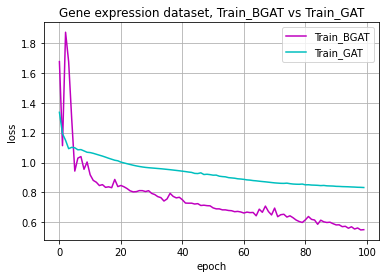

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_BGAT_, "m")
plt.plot(train_loss_GAT_, "c")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train_BGAT','Train_GAT'])
plt.title('Gene expression dataset, Train_BGAT vs Train_GAT')
plt.grid()
plt.show()